# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [4]:
# environment

load_dotenv()
#os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Load in the test pickle file:

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [37]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [9]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [10]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [11]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [38]:
print(len(vectors), len(documents), len(prices))  # Check lengths

20000 20000 20000


In [42]:
# Me, just want to see the pred, next to the data
import pandas as pd

# Get predictions
predicted_prices = rf_model.predict(vectors)

# Create a DataFrame with input documents and their predicted prices
df = pd.DataFrame({
    'Actual Price': prices,
    'Predicted Price': predicted_prices,
    'Document': documents
})

# Display results
display(df.head(10))  # Show first few rows

,Actual Price,Predicted Price,Document
0,37.99,51.1158,Kid Galaxy Amphibious RC Car Mega Morphibians ...
1,36.32,45.1102,SmartLab Drop Zone Science Kit\nLoad the plane...
2,24.99,35.3757,"Kids Block Table, Childrens Educational Toy 69..."
3,22.49,20.0574,1S Lipo Battery Charging Board Blade Inductrix...
4,11.99,23.9982,AxcessAbles 1/4 Inch TRS Instrument Cable 5ft ...
5,44.99,37.8660,Motorola Bluetooth Earpiece HK385 in-Ear Wirel...
6,25.06,38.0530,Lowrance Elite 4/Mark 4 HDI Sun/Dust Cover\nLa...
7,39.99,57.6573,Cheerwing RC Racing Boat for Adults - High Spe...
8,139.99,101.7222,Pokemon TCG Shining Legends Premium Collection...
9,7.02,10.3088,PC-CASE 0.5ft Rf Connector Rp-SMA Female to Rp...


In [16]:
#from agents.specialist_agent import SpecialistAgent
#from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [18]:
#specialist = SpecialistAgent()
#frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [12]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [13]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $63.40 Truth: $32.77 Error: $30.63 SLE: 0.42 Item: 𝐎𝐄𝐌 DC97-15459G Water Inlet Valve for SA...
2: Guess: $108.19 Truth: $399.99 Error: $291.80 SLE: 1.69 Item: ROVSUN 150lbs/24h Commercial Ice Maker w...
3: Guess: $29.60 Truth: $22.37 Error: $7.23 SLE: 0.07 Item: W10619844 Washer Lid Lock Latch Switch O...
4: Guess: $41.10 Truth: $14.99 Error: $26.11 SLE: 0.94 Item: 3204425 Washing Machine Washer Idler Pul...
5: Guess: $70.17 Truth: $17.49 Error: $52.68 SLE: 1.82 Item: MSDADA Stove Top Cover for Electric Stov...
6: Guess: $58.20 Truth: $11.99 Error: $46.21 SLE: 2.30 Item: EFIELD 10 FT Stainless Steel Braided Ice...
7: Guess: $49.90 Truth: $49.95 Error: $0.05 SLE: 0.00 Item: 5304483506 Dishwasher Silverware Basket ...
8: Guess: $41.11 Truth: $11.99 Error: $29.12 SLE: 1.38 Item: American Metal Filter RHF0802 Aluminum G...
9: Guess: $37.33 Truth: $5.77 Error: $31.56 SLE: 3.01 Item: Sikawai Unbreakable W10714516 W10861225 ...
10: Guess: $34.67 Truth: $13.99 Error: $20.68 SLE: 0.75

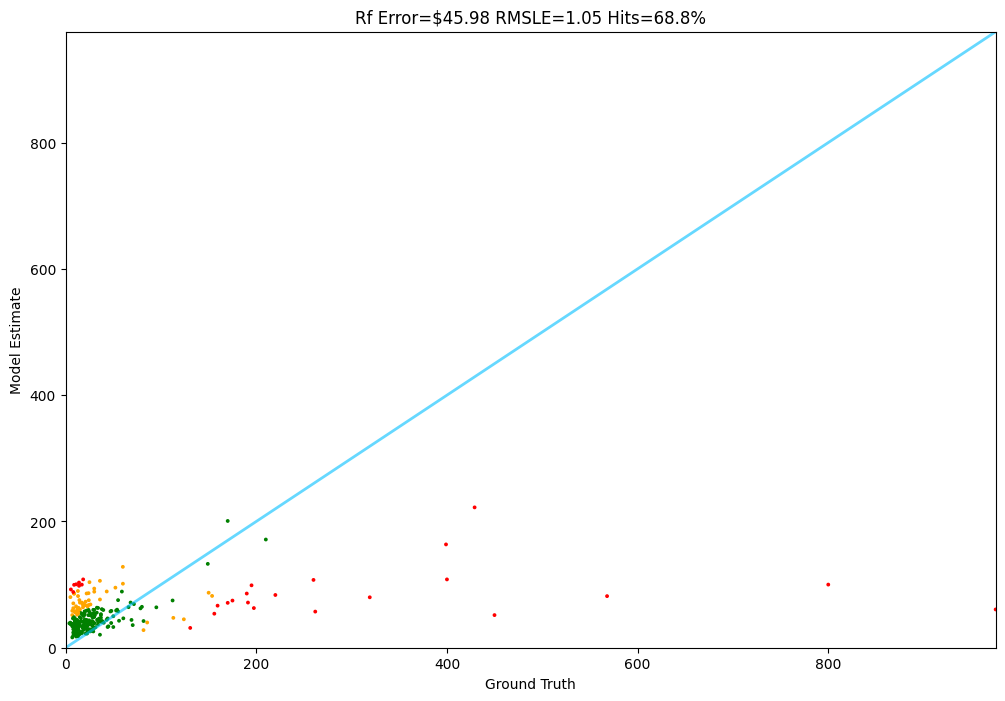

In [19]:
Tester.test(rf, test)

In [20]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [21]:
#print(specialist.price(product))
#print(frontier.price(product))
print(random_forest.price(product))

74.80429999999993


In [22]:
# specialists = []
# frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    # specialists.append(specialist.price(text))
    # frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [00:31<00:00,  8.01it/s]


In [23]:
# mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
# maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
mins = [min(r) for r in zip(random_forests)]
maxes = [max(r) for r in zip(random_forests)]

X = pd.DataFrame({
    # 'Specialist': specialists,
    # 'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [24]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

RandomForest: 0.39
Min: 0.39
Max: 0.39
Intercept=-16.91


In [ ]:
joblib.dump(lr, 'ensemble_model.pkl')

In [ ]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [ ]:
ensemble.price(product)

In [ ]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

In [ ]:
Tester.test(ensemble_pricer, test)

# WHAT A DAY!

We got so much done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.

You can do better, for sure!

Tweak this, and try adding components into the ensemble, to beat my performance.